In [1]:
%load_ext autoreload
%autoreload 2
# imports
import time

# important libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy as sp

from tqdm.auto import tqdm
import itertools

# for better printing of variables
from IPython.display import display

# custom imports
from concperf import single_model, general_model
from concperf import utility

In [2]:
# update configuration dictionary for each instance count
def update_config(config):
    config['arrival_rate_server'] = config['arrival_rate_total'] / config['instance_count']
    config['base_service_time'] = config['base_service_time_ms'] / 1000
    config['stable_conc_avg_count'] = 10 * config['instance_count']

# target utilization
target_util = 0.7


# model_config = {
#     # 'instance_count' should be added for each state
#     'max_conc': 100,
#     'arrival_rate_total': 10,
#     'alpha': 0.11,
#     'base_service_time_ms': 1154,
#     'max_container_count': 25,
#     'target_conc': 1*target_util, # assumes target utilization
#     'max_scale_up_rate': 1000, # from N to 1000*N at most
#     'max_scale_down_rate': 2, # from N to N/2 at most
#     # 'stable_conc_avg_count': 60, # number of times monitored concurrency will be averaged in stable mode
#     'autoscaling_interval': 2, # amount of time between autoscaling evaluations
#     'provision_rate_base': 1,
#     'deprovision_rate_base': 2,
# }

# trying new model extracted params
model_config = {
    # 'instance_count' should be added for each state
    'max_conc': 10,
    'arrival_rate_total': 10,
    'alpha': 0.102,
    'base_service_time_ms': 1180,
    'max_container_count': 40,
    'target_conc': 1*target_util, # assumes target utilization
    'max_scale_up_rate': 1000, # from N to 1000*N at most
    'max_scale_down_rate': 2, # from N to N/2 at most
    # 'stable_conc_avg_count': 60, # number of times monitored concurrency will be averaged in stable mode
    'autoscaling_interval': 2, # amount of time between autoscaling evaluations
    'provision_rate_base': 1,
    'deprovision_rate_base': 2,
}

# test
# model_config = {
#     # 'instance_count' should be added for each state
#     'max_conc': 100,
#     'arrival_rate_total': 15,
#     'alpha': 1,
#     'base_service_time_ms': 120,
#     'max_container_count': 25,
#     'target_conc': 1*target_util, # assumes target utilization
#     'max_scale_up_rate': 1000, # from N to 1000*N at most
#     'max_scale_down_rate': 2, # from N to N/2 at most
#     # 'stable_conc_avg_count': 60, # number of times monitored concurrency will be averaged in stable mode
#     'autoscaling_interval': 2, # amount of time between autoscaling evaluations
#     'provision_rate_base': 1,
#     'deprovision_rate_base': 2,
# }

In [3]:
# sample execution
# res = general_model.solve_general_model(model_config, update_config)
# res_params = general_model.calculate_general_params(res, model_config)
# res.update(res_params)
# res.keys()

# Arrival Rate Plots

In [4]:
arrival_rates = list(np.linspace(1, 30, 10))

def parse_arrival_rate(arrival_rate):
    config = {**model_config}
    config.update({
        'arrival_rate_total': arrival_rate,
    })
    res = general_model.solve_general_model(config, update_config)
    res_params = general_model.calculate_general_params(res, config)
    res.update(res_params)
    res.update(config)
    return res

start_time = time.time()
total_results = list(map(parse_arrival_rate, tqdm(arrival_rates, position=0, leave=True)))
elapsed_time = time.time() - start_time
print(f"\nnew order calculation took {elapsed_time} seconds for {len(arrival_rates)} arrival rates ({elapsed_time/len(arrival_rates):4.2f} per job)")

  0%|          | 0/10 [00:00<?, ?it/s]


new order calculation took 1758.8326506614685 seconds for 10 arrival rates (175.88 per job)


In [5]:
extract_keys = [
    'arrival_rate_total', 
    'ready_avg', 
    'ordered_avg', 
    'req_count_avg', 
    'resp_time_avg', 
]

def extract_params(total_results, model_config):
    extract_vals = []
    for r in total_results:
        extract_vals.append({k:r[k] for k in extract_keys})
    resdf = pd.DataFrame(data=extract_vals)
    resdf['cc'] = int(model_config['target_conc']/target_util)
    return resdf


resdf = extract_params(total_results, model_config)
resdf

,arrival_rate_total,ready_avg,ordered_avg,req_count_avg,resp_time_avg,cc
0,1.000000,2.195950,2.232008,0.625934,1229.782215,1
1,4.222222,8.016462,8.089943,0.677511,1230.184548,1
2,7.444444,13.810465,13.908990,0.688420,1230.688059,1
3,10.666667,19.575397,19.696112,0.694281,1231.041960,1
4,13.888889,25.415030,25.553317,0.695277,1231.074931,1
5,17.111111,31.209210,31.364717,0.697204,1231.227267,1
6,20.333333,36.882858,37.040356,0.700702,1231.504835,1
7,23.555556,39.841335,39.867310,0.753059,1235.574767,1
8,26.777778,39.975749,39.987870,0.861934,1244.416594,1
9,30.000000,39.969920,39.984982,0.976479,1253.960363,1


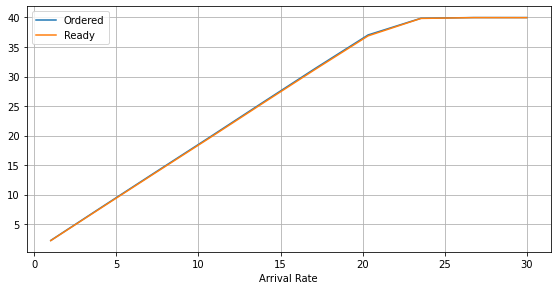

In [6]:
def default_plt_configs():
    plt.figure(figsize=(8,4))
    plt.grid(True)
    plt.tight_layout()
    plt.xlabel('Arrival Rate')

default_plt_configs()
# number of ordered instances
plt.plot(resdf['arrival_rate_total'], resdf['ordered_avg'], label='Ordered')
# number of ready instances
plt.plot(resdf['arrival_rate_total'], resdf['ready_avg'], label='Ready')
plt.legend()

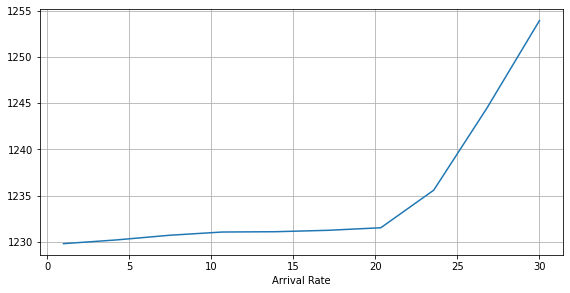

In [7]:
default_plt_configs()
# average response time
plt.plot(resdf['arrival_rate_total'], resdf['resp_time_avg'])

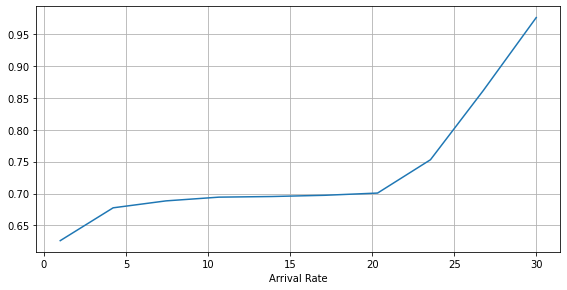

In [8]:
# average concurrency per server
default_plt_configs()
plt.plot(resdf['arrival_rate_total'], resdf['req_count_avg'])

# Overall Arrival Rate Plots

In [ ]:
# calculate parameters for differenct concurrencies
# ccs = [1,2,4,8,16]
ccs = [1,3,5]

tresdf = pd.DataFrame()
for cc in ccs:
    model_config.update({
        'target_conc': cc * target_util,
    })
    total_results = list(map(parse_arrival_rate, tqdm(arrival_rates, position=0, leave=True)))
    resdf = extract_params(total_results, model_config)
    tresdf = tresdf.append(resdf)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
total_res = tresdf.set_index('arrival_rate_total')
total_res['cc_legend'] = total_res['cc'].apply(lambda x: f"CC={x:2.0f}")
tresdf.head()

In [ ]:
# number of instances plot
default_plt_configs()
total_res.groupby('cc_legend')['ready_avg'].plot(legend=True)
plt.ylabel('Ready Instance Count')
plt.xlim([0,20])
plt.grid(True)

In [ ]:
# concurrency per server (needs further investigation)
default_plt_configs()
plt.ylabel('Average Concurrency Level')
total_res['test_req_count_avg'] = total_res['req_count_avg'] / 1.2
total_res.groupby('cc_legend')['test_req_count_avg'].plot(legend=True)
plt.grid(True)
# plt.ylim([0,5])
plt.xlim([0,20])